# Buy when Yields are Low

In [20]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

import utils as self_utils
from quantified_strategies import strategy_utils

## Rules

- Buy S&P 500 at the close when the 10 year yield drops below its 15-day exponential moving average; and
- Exit at the close when the yield crosses above its 15-day exponential moving average.

In [21]:
# self_utils.run(ticker="^GSPC", start=dt.date(2020, 1, 1), end=dt.date.today(), full=True)

In [22]:
START = dt.date(2015, 1, 1)
ASSET_DAY_AFTER = False


In [23]:
TICKER = "SPY5.L" #5.DE"
# TICKER = "NQSE.DE"
# TICKER = "QQQ3.MI"
TICKER = "SPY"

In [24]:
ty10 = yf.download("^TNX", progress=False)["Close"]
px = yf.download(TICKER, progress=False)["Close"]

ty10 = ty10[ty10.index.date >= START]
px = px[px.index.date >= START]
px

Date
2015-01-02    205.429993
2015-01-05    201.720001
2015-01-06    199.820007
2015-01-07    202.309998
2015-01-08    205.899994
                 ...    
2024-02-23    507.850006
2024-02-26    505.989990
2024-02-27    506.929993
2024-02-28    506.260010
2024-02-29    508.079987
Name: Close, Length: 2305, dtype: float64

In [25]:
ty10_15_day_ma = self_utils.calculate_ema(data=ty10, window=15)
ty10_15_day_ma

Date
2015-01-02    2.123000
2015-01-05    2.112500
2015-01-06    2.093812
2015-01-07    2.076336
2015-01-08    2.068794
                ...   
2024-02-23    4.225673
2024-02-26    4.234839
2024-02-27    4.244859
2024-02-28    4.248502
2024-02-29    4.248939
Name: Close, Length: 2303, dtype: float64

In [26]:
signal1 = self_utils.get_position(treasury=ty10, window=15)
signal1.head(5)

Date
2015-01-02    False
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08     True
Name: Close, dtype: bool

In [27]:
signal2 = self_utils.get_position(treasury=ty10, window=15, reverse=True)
signal2.head(5)

Date
2015-01-02    False
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08    False
Name: Close, dtype: bool

In [28]:
hodl_signal = pd.Series(1, index=signal1.index)

In [29]:
rets = px.pct_change().shift(-1-ASSET_DAY_AFTER)
rets

Date
2015-01-02   -0.018060
2015-01-05   -0.009419
2015-01-06    0.012461
2015-01-07    0.017745
2015-01-08   -0.008014
                ...   
2024-02-23   -0.003663
2024-02-26    0.001858
2024-02-27   -0.001322
2024-02-28    0.003595
2024-02-29         NaN
Name: Close, Length: 2305, dtype: float64

In [30]:
portfolio1_returns = (rets * signal1).dropna()
portfolio1_value = (portfolio1_returns + 1).cumprod()
portfolio1_value.head(5)

Date
2015-01-02         1.0
2015-01-05         1.0
2015-01-06         1.0
2015-01-07         1.0
2015-01-08    0.991986
Name: Close, dtype: object

In [31]:
portfolio2_returns = (rets * signal2).dropna()
portfolio2_value = (portfolio2_returns + 1).cumprod()
portfolio2_value.head(5)

Date
2015-01-02    1.0
2015-01-05    1.0
2015-01-06    1.0
2015-01-07    1.0
2015-01-08    1.0
Name: Close, dtype: object

In [32]:
hodl_value = ((rets * hodl_signal).dropna() + 1).cumprod()
hodl_ret = (rets * hodl_signal).dropna().cumsum()
hodl_value.head(5)

Date
2015-01-02    0.981940
2015-01-05    0.972691
2015-01-06    0.984812
2015-01-07    1.002288
2015-01-08    0.994256
dtype: float64

## Plot Strategy Results

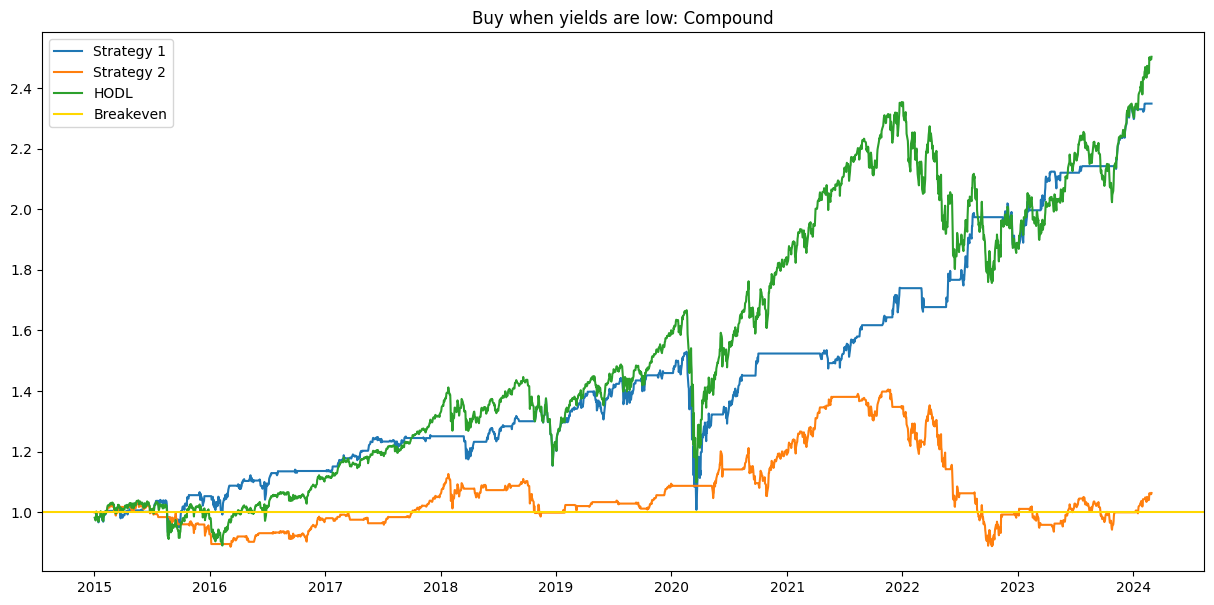

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(portfolio1_value, label="Strategy 1")
ax.plot(portfolio2_value, label="Strategy 2")
ax.plot(hodl_value, label="HODL")
ax.axhline(y=1, label="Breakeven", color="gold")

ax.legend(loc="upper left")
plt.title("Buy when yields are low: Compound")
plt.show()

In [34]:
# TODO: Add vertical lines to show when long and when neutral

## Describe Strategy Results

In [35]:
pd.concat([
    strategy_utils.describe(returns=portfolio1_returns, pos=signal1, daily=True, asset=TICKER).to_frame(name="Strategy 1"),
    strategy_utils.describe(returns=portfolio2_returns, pos=signal2, daily=True, asset=TICKER).to_frame(name="Strategy 2"),
    strategy_utils.describe(returns=rets, daily=True, asset=TICKER).to_frame(name="HODL"),
], axis=1)

,Strategy 1,Strategy 2,HODL
Asset,SPY,SPY,SPY
Start,2015-01-02,2015-01-02,2015-01-02
End,2024-02-28,2024-02-28,2024-02-29
Mean Return,0.08842%,0.00993%,0.04582%
Total Return,134.84%,6.34%,147.33%
Median Return,0.08918%,0.03920%,0.05358%
1st Quartile,-0.37045%,-0.40131%,-0.39065%
3rd Quartile,0.66845%,0.52066%,0.59205%
Std Dev Return,1.28523%,0.99301%,1.13888%
CAGR,8.012 bps,0.499 bps,3.929 bps


In [36]:
df1 = pd.concat([signal1, rets], axis=1)
df1.columns = ["signal", "ret"]
df1 = df1.sort_index()
df1["trade_num"] = df1["signal"].diff().clip(lower=0.0).cumsum()
df1 = df1.loc[df1["signal"] > 0]
df1["trade_num"] = df1["trade_num"].map(df1.reset_index().groupby("trade_num")["Date"].first().to_dict())

df2 = pd.concat([signal2, rets], axis=1)
df2.columns = ["signal", "ret"]
df2 = df2.sort_index()
df2["trade_num"] = df2["signal"].diff().clip(lower=0.0).cumsum()
df2 = df2.loc[df2["signal"] > 0]
df2["trade_num"] = df2["trade_num"].map(df2.reset_index().groupby("trade_num")["Date"].first().to_dict())


In [37]:
df1

,signal,ret,trade_num
Date,,,
2015-01-08,True,-0.008014,2015-01-08
2015-01-09,True,-0.007834,2015-01-08
2015-01-12,True,-0.002813,2015-01-08
2015-01-13,True,-0.006037,2015-01-08
2015-01-14,True,-0.009161,2015-01-08
...,...,...,...
2024-01-08,True,-0.001517,2023-11-06
2024-02-02,True,-0.003641,2024-02-02
2024-02-05,True,0.002903,2024-02-02


In [38]:
pd.concat([
    strategy_utils.describe(returns=df1.groupby("trade_num")["ret"].apply(lambda x: strategy_utils.get_cumulative_return(returns=x, total=True)), daily=False, asset=TICKER).to_frame(name="Strategy 1"),
    strategy_utils.describe(returns=df2.groupby("trade_num")["ret"].apply(lambda x: strategy_utils.get_cumulative_return(returns=x, total=True)), daily=False, asset=TICKER).to_frame(name="Strategy 2"),
    strategy_utils.describe(returns=rets, daily=True, asset=TICKER).to_frame(name="HODL"),
], axis=1)

,Strategy 1,Strategy 2,HODL
Asset,SPY,SPY,SPY
Start,2015-01-08,2015-02-10,2015-01-02
End,2024-02-02,2024-02-08,2024-02-29
Mean Return,1.75763%,0.21587%,0.04582%
Total Return,134.84%,5.37%,147.33%
Median Return,1.30328%,0.24490%,0.05358%
1st Quartile,0.09741%,-1.91415%,-0.39065%
3rd Quartile,3.61178%,2.17435%,0.59205%
Std Dev Return,3.79415%,4.91588%,1.13888%
CAGR,168.810 bps,10.269 bps,3.929 bps
